In [1]:
import sys
import os
import copy
import pathlib
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import PredictionErrorDisplay
from sklearn.metrics import r2_score


In [2]:
FILE_PATH = globals()['_dh'][0]
CODES_LOC = FILE_PATH.parent
AUG2022_LOC = FILE_PATH.parent.parent
MODELS_LOC = os.path.join(AUG2022_LOC, "MLmodels", "Training1_Jan2023", "models")
DYNAMICTEST_LOC = os.path.join(AUG2022_LOC, "MLmodels", "Dynamic1_Jan2023")
DYNAMICTEST_PREDS_LOC = os.path.join(DYNAMICTEST_LOC, "predictions")

sys.path.insert(0, str(CODES_LOC))
sys.path.insert(0, str(AUG2022_LOC))
from Codes.Dynamic.helpers.procothersources_helper import ProcOtherSourcesOffline
from Codes.Dynamic.helpers.procpreds_helper import ProcPredsOffline
from Codes.Dynamic.helpers.procdata_helper import proc_data

STATE_MODEL_NAME = "model_fno1d_valSplit"
LIFTDRAG_MODEL_NAME = "model_fno1d_valSplit_LiftDrag"
DYNAMICTEST_NAMES = ["dynamic1_run15", "dynamic1_run16", "dynamic1_run17", "dynamic1_run18"]
ENCODER_NAME = None #encoder_ResNet18_dynVal for state model model_ResNet18_dynVal_ph10

In [3]:
# DAQ properties
DAQ_SAMPLERATE = 10000
WINDOW_SIZE = 333 #(10000/30=333) Inference in every 1/30 seconds
DATA_PER_SECOND = int(DAQ_SAMPLERATE/WINDOW_SIZE) #30 predictions per second
MEAN_DICT = {'PZT 1': 1.1964636626483654e-05, 'PZT 2': 1.516750592542323e-05, 'PZT 3': 1.2442148594709227e-05, 'PZT 4': 2.4788622977256767e-05, 'PZT 5': -3.7253732809026377e-07, 'PZT 6': 1.0824012458478593e-05, 'PZT 7': 1.1674180171877221e-05, 'SG 1': -6.594330432620959e-05, 'SG 2': -0.00010346779513860188, 'SG 5': -7.36565906801972e-05}
STD_DICT = {'PZT 1': 8.041994739151683e-05, 'PZT 2': 7.549385118018473e-05, 'PZT 3': 8.428371907009408e-05, 'PZT 4': 0.0001256689655046649, 'PZT 5': 8.544440378484743e-05, 'PZT 6': 9.837018189303782e-05, 'PZT 7': 0.00013566630247286284, 'SG 1': 4.3046127066776684e-05, 'SG 2': 7.459676011368966e-05, 'SG 5': 5.162082415922712e-05}

ALL_SENSORS = ['PZT 1', 'PZT 2', 'PZT 3', 'PZT 4', 'PZT 5', 'PZT 6', 'PZT 7',
               'SG 1', 'SG 2', 'SG 4', 'SG 5', 'SG 6', 'SG LE', 'SG TE']
ACTIVE_SENSORS = ['PZT 1', 'PZT 2', 'PZT 3', 'PZT 4', 'PZT 5', 'PZT 6', 'PZT 7',
                  'SG 1', 'SG 2', 'SG 5']

In [4]:
# Here test_data.shape = (#of sensors, #of sensor readings in the experiment) (14, 5366200 for Aug. 2022 Dynamic1 Run15)
# test_data: 10,000sps * ~9 minutes per run
airspeeds = np.arange(1,25, dtype=float)
airspeeds[7] = 8.3
aoas = np.arange(0,20, dtype=float)

aoa_ixs = {k: [] for k in aoas}
mse_perstate = {k: copy.deepcopy(aoa_ixs) for k in airspeeds}

for dynamic_test in DYNAMICTEST_NAMES:
  test_data = np.load(os.path.join(DYNAMICTEST_LOC, "data", dynamic_test+".npy"), allow_pickle=True)
  with open(os.path.join(DYNAMICTEST_LOC, "labels", dynamic_test+"_truth_nopeaks.pkl"), 'rb') as f:
    test_truth_state = pickle.load(f)

  # Process the sensor data
  test_data, test_truth_state = proc_data(test_data, test_truth_state, ALL_SENSORS, ACTIVE_SENSORS, WINDOW_SIZE, MEAN_DICT, STD_DICT)

  # Bring in the ground truth data
  offline_other_sources = ProcOtherSourcesOffline(test_truth_state)
  truth_data_dict = offline_other_sources.get_truth_state() #truth_data['airspeed'], truth_data['aoa'], truth_data['lift'], truth_data['drag']

  # Extract variables of interest from the entire dict
  airspeed_truth = truth_data_dict['airspeed']
  aoa_truth = truth_data_dict['aoa']
  lift_truth = truth_data_dict['lift']
  drag_truth = truth_data_dict['drag']
  truth_data = np.stack((airspeed_truth, aoa_truth, lift_truth, drag_truth)).T

  # Bring in the predictions
  offline_preds = ProcPredsOffline(test_data, truth_data_dict, DYNAMICTEST_PREDS_LOC, dynamic_test)
  airspeed_preds, aoa_preds = offline_preds.get_preds_state(MODELS_LOC, STATE_MODEL_NAME, ENCODER_NAME)
  lift_preds, drag_preds = offline_preds.get_preds_liftdrag(MODELS_LOC, LIFTDRAG_MODEL_NAME)
  preds_data = np.stack((airspeed_preds, aoa_preds, lift_preds, drag_preds)).T

  # Create an array that only masks the AoAs < 0.
  aoa_lowerbound = truth_data[:,1]>=0
  dyn_mask = np.where([aoa_lowerbound], True, False)
  dyn_mask = dyn_mask.all(axis = 0)

  contain_ixs = np.nonzero(dyn_mask)[0]
  
  for ix in contain_ixs:
    rounded_airspeed = float(round(truth_data[ix,0]))
    rounded_airspeed = 8.3 if rounded_airspeed == 8.0 else rounded_airspeed
    rounded_aoa = float(round(truth_data[ix,1]))
    mse = (truth_data[ix,0] - preds_data[ix,0])**2 + (truth_data[ix,1] - preds_data[ix,1])**2
    mse_perstate[rounded_airspeed][rounded_aoa].append(mse)

mse_arr = np.zeros((len(airspeeds), len(aoas)))
absent_states = np.zeros((len(airspeeds), len(aoas)))

for vi,airspeed in enumerate(airspeeds):
  for ai,aoa in enumerate(aoas):
    if len(mse_perstate[airspeed][aoa]) > 10:
      mse_perstate[airspeed][aoa] = np.sum(mse_perstate[airspeed][aoa]) / len(mse_perstate[airspeed][aoa])
    else:
      mse_perstate[airspeed][aoa] = -1
      absent_states[vi,ai] = 1
    mse_arr[vi,ai] = mse_perstate[airspeed][aoa]


In [6]:
# Method 2 to replace -1.0 values: 
# By finding closest 4 items based on Euclidean distance and take their weighted average based on distance
def get_indices_of_k_smallest(arr, k):
    idx = np.argpartition(arr.ravel(), k)
    return tuple(np.array(np.unravel_index(idx, arr.shape))[:, range(min(k, 0), max(k, 0))])

state_grid = np.zeros((airspeeds.shape[0], aoas.shape[0]))
for i in range(state_grid.shape[0]):
  for j in range(state_grid.shape[1]):
    state_grid[i,j] = airspeeds[i]+aoas[j]

for vi,airspeed in enumerate(airspeeds):
  for ai,aoa in enumerate(aoas):
    if mse_perstate[airspeed][aoa] == -1:
      distance_grid = np.zeros_like(state_grid)
      dx = np.abs(airspeed - airspeeds)
      dy = np.abs(aoa - aoas)
      repeated_dx = np.tile(dx, (aoas.shape[0],1)).T
      repeated_dy = np.tile(dy, (airspeeds.shape[0],1))
      euclidean_distances = np.sqrt(repeated_dx ** 2 + repeated_dy ** 2)
      euclidean_distances[absent_states == 1] = np.inf #Exclude absent states from this calculation
      euclidean_distances[vi,ai] = np.inf #Exclude the query state from this calculation

      four_smallest_ix = get_indices_of_k_smallest(euclidean_distances, 4) 
      
      dist_sum = 0
      for i in range(four_smallest_ix[0].shape[0]):
        dist_sum += 1 / euclidean_distances[four_smallest_ix[0][i]][four_smallest_ix[1][i]]

      mse_sum = 0
      for i in range(four_smallest_ix[0].shape[0]):
        airspeed_q = airspeeds[four_smallest_ix[0][i]]
        aoa_q = aoas[four_smallest_ix[1][i]]
        mse_sum += mse_perstate[airspeed_q][aoa_q] * (1/euclidean_distances[four_smallest_ix[0][i]][four_smallest_ix[1][i]]) / dist_sum

      mse_perstate[airspeed][aoa] = mse_sum
      mse_arr[vi,ai] = mse_perstate[airspeed][aoa]

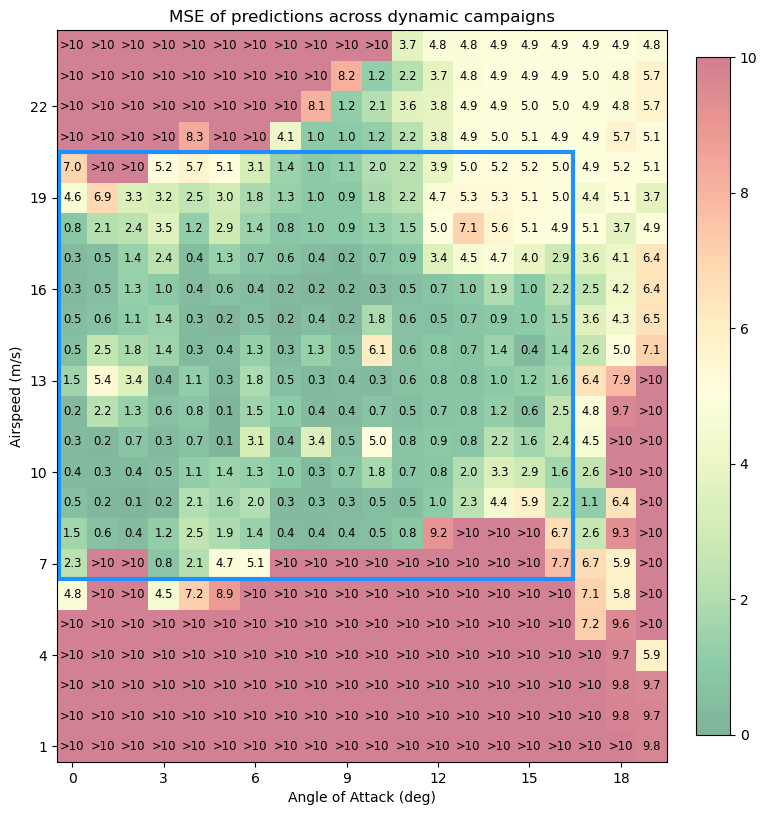

In [7]:
fig, ax = plt.subplots(figsize=(9.5, 9.5))
mse_clrs = ax.matshow(mse_arr, cmap=plt.cm.RdYlGn_r, alpha=0.5, vmin=0, vmax=10, origin='lower')

for vi,airspeed in enumerate(airspeeds):
  for ai,aoa in enumerate(aoas):
    if mse_perstate[airspeed][aoa] > 10:
      ax.text(ai, vi, s=">10", va='center', ha='center', fontsize="small")
    else:
      ax.text(ai, vi, s="{:.1f}".format(mse_perstate[airspeed][aoa]), va='center', ha='center', fontsize="small")

#Draw horizontal and vertical lines to designate training region
ax.hlines(y=5.5, xmin=-0.5, xmax=16.5, linewidth=3, color='dodgerblue')
ax.hlines(y=19.5, xmin=-0.5, xmax=16.5, linewidth=3, color='dodgerblue')
ax.vlines(x=-0.425, ymin=5.5, ymax=19.5, linewidth=3, color='dodgerblue')
ax.vlines(x=16.425, ymin=5.5, ymax=19.5, linewidth=3, color='dodgerblue')

ax.set_xlabel("Angle of Attack (deg)")
ax.set_ylabel("Airspeed (m/s)")
aoa_ticks = np.arange(0, 20, step=3) #0, 3, 6, 9, 12, 15, 18, 21
airspeed_ticks = np.arange(0, 24, step=3) #0, 3, 6, 9, 12, 15, 18, 21, 24

ax.set_xticks(aoa_ticks)
ax.xaxis.set_ticks_position("bottom")
ax.set_yticks(airspeed_ticks, ["1" ,"4" ,"7", "10", "13", "16", "19", "22"])

plt.colorbar(mse_clrs,fraction=0.046, pad=0.04)
plt.title("MSE of predictions across dynamic campaigns")
plt.savefig("dyn_deviation_v3.png", dpi=300)